In [2]:
# Import libraries

import matplotlib.pyplot as plt
import scipy.signal
import numpy as np
import threading
import time
import sys
import pandas as pd
import math
from sklearn import linear_model
import tensorflow as tf
from BaselineRemoval import BaselineRemoval

%matplotlib inline

# Get and preprocess data


In [22]:
# Get event data (labels) and EEG raw data
# Data from different subjects can be found here: https://github.com/janlucasandmann/Brainbridge/tree/main/data

events_raw = np.genfromtxt("https://raw.githubusercontent.com/janlucasandmann/Brainbridge/main/data/JS/JS-i4-labels.csv", dtype=float, delimiter=',') 
data_raw = np.genfromtxt("https://raw.githubusercontent.com/janlucasandmann/Brainbridge/main/data/JS/JS-i4.csv", dtype=float, delimiter=',') 

# Cut out elements, that are outside the events dataset
data_raw = data_raw[:len(events_raw) * 200]

In [23]:
# Split data array into sets of 200 elements --> Raw EEG data is recorded in intervals of 2 seconds with a frequency of
# 100Hz, which is why 200 elements refer to one element in the events_raw list

u = 0

data_row = []
data_split = []

for i in data_raw:
  u += 1
  data_row.append(float(i))

  if u == 200:
    data_split.append(data_row)
    u = 0
    data_row = []

## Artifact Removal

In [24]:
# Cut out extremely high or low values --> these intervals are probably falsified by measuring errors

upper_limit = 1000 # measured in microvolts
lower_limit = 200 # measured in microvolts

data = []
events = []
c = 0

for i in data_split:
  extreme_value_found = False

  for x in i:
    if x >= upper_limit or x <= lower_limit:
      extreme_value_found = True
      break
  
  if not extreme_value_found:
    data.append(i)
    events.append(events_raw[c])
    c += 1

# Filtering functions

In [21]:
# Define bandpass filter functions, which will be used to filter the data to different frequencies

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = scipy.signal.butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = scipy.signal.sosfilt(sos, data)
        return y

In [42]:
# Define Tapering function
# Each interval consists of 200 elements. The first and last elements are not as relevant as the
# elements in the middle of the interval. There are many cases, in which these marginal values are very high or low,
# which falsifies computation of mean, standard deviation, etc. This is, why tapering is needed.

w = np.hamming(200)
tapering_function = []

for i in w:
  tapering_function.append(i * 1)

def applyTapering(data, zeros):
  res = []
  zero_list = [0] * zeros

  for x in data:
    c = 0
    res_row = []
    for i in x:
      res_row.append(i * tapering_function[c])
      c += 1

    res.append(zero_list + res_row + zero_list)

  return res

In [28]:
# Define function for extracting features, that describe the 200 datapoints of an interval as a whole.
# This function extracts arrithmetic mean, standard deviation, the highest or lowest value of an interval (= top_val),
# the greatest differences between two datapoints on the positive and negative side (= baseline_difference_top,
# baseline_difference_bottom) and each of these values after the interval runs through a Fourier transformation.

def computeFeatures(data, temp_top_val):
  mean_row = []
  std_row = []
  temp_baseline_difference_bottom = 0
  temp_baseline_difference_top = 0

  for i in data:
    i = float(i)
    if temp_baseline_difference_bottom == 0:
      temp_baseline_difference_bottom = math.sqrt(i ** 2)
    else:
      if math.sqrt(i ** 2) < temp_baseline_difference_bottom:
        temp_baseline_difference_bottom = math.sqrt(i ** 2)
    
    if math.sqrt(i ** 2) > temp_baseline_difference_top:
      temp_baseline_difference_top = math.sqrt(i ** 2)

    if math.sqrt(i ** 2) > temp_top_val:
      temp_top_val = math.sqrt(i ** 2)
    mean_row.append(math.sqrt(i ** 2))
    std_row.append(i)

    if math.sqrt(i ** 2) > temp_top_val:
        temp_top_val = math.sqrt(i ** 2)

  return [mean_row, std_row, temp_baseline_difference_bottom, temp_baseline_difference_top, temp_top_val]

def getFeatures(lowcut, highcut, input_data):
  means = []
  std = []
  top_val = []
  temp_top_val = 0
  baseline_difference = []
  # Apply fourier transform to get energy distribution on different frequencies
  means_fft = []
  std_fft = []
  top_val_fft = []
  temp_top_val_fft = 0
  baseline_difference_fft = []

  for i in input_data:

    filtered = butter_bandpass_filter(i- np.mean(i), lowcut=lowcut, highcut=highcut, fs=100)
    filtered_fft = np.fft.fftn(filtered)

    res = computeFeatures(filtered, temp_top_val)
    res_fft = computeFeatures(filtered_fft, temp_top_val_fft)
    
    baseline_difference.append(res[3] - res[2])
    baseline_difference_fft.append(res_fft[3] - res_fft[2])

    top_val.append(res[4])
    top_val_fft.append(res_fft[4])

    means.append(np.average(res[0]))
    means_fft.append(np.average(res_fft[0]))

    std.append(np.std(res[1]))
    std_fft.append(np.std(res_fft[1]))
    
  return [means, std, top_val, baseline_difference, means_fft, std_fft, top_val_fft, baseline_difference_fft]

In [29]:
# Define function to get averaged datapoints for the different event classes (in this case hand up or down).
# This will be used to measure distances between a given interval and the averaged intervals for the event classes
# to determine, which class is the nearest to the given interval.

def getAverages(data):

  average_up = []
  average_down = []
  c = 0

  for i in data:
    if events[c] == 1:
      average_up.append(i)
    else:
      average_down.append(i)
    c += 1

  average_up_transpose = np.transpose(average_up)
  average_down_transpose = np.transpose(average_down)

  average_up_res = []
  average_down_res = []

  for i in average_up_transpose:
    average_up_res.append(np.average(i))
  
  for i in average_down_transpose:
    average_down_res.append(np.average(i))
    
  return average_up_res, average_down_res

# Feature Extraction via time frequency analysis

Extract features, that describe the energy distribution at different
frequencies for all intervals.

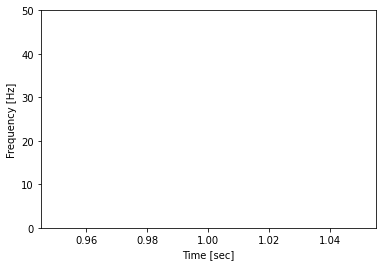

In [13]:
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt

f, t, Sxx = signal.spectrogram(np.array(data[0]), 100)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

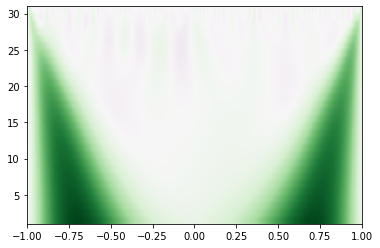

In [14]:
from scipy import signal
import matplotlib.pyplot as plt
t = np.linspace(0, 200, 800, endpoint=False)
sig  = data[16]
widths = np.arange(1, 31)
cwtmatr = signal.cwt(sig, signal.ricker, widths)
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto', vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.show()

# Feature Extraction via extreme Points

Identify local minima and maxima in all intervals and extract features based on that.

In [30]:
# Define functions to find extreme points in the intervals, average them for the different events and measure the distance
# from a given interval to the averaged extreme points from the different classes.

def findLocalExtremes(up, down, scaler):
  minima_up = []
  maxima_up = []
  minima_down = []
  maxima_down = []

  i = 0

  while i < len(up):
    minima_up.append(np.min(up[i:i+scaler]))
    maxima_up.append(np.max(up[i:i+scaler]))
    minima_down.append(np.min(down[i:i+scaler]))
    maxima_down.append(np.max(down[i:i+scaler]))
    i += scaler

  return minima_up, maxima_up, minima_down, maxima_down

def findLocalExtremesRow(row, scaler):
  minima = []
  maxima = []

  i = 0

  while i < len(row):
    minima.append(np.min(row[i:i+scaler]))
    maxima.append(np.max(row[i:i+scaler]))
    i += scaler

  return minima, maxima
  
def extremePointsCorrelation(data, scaler):
  avg_up, avg_down = getAverages(data)
  minima_up, maxima_up, minima_down, maxima_down = findLocalExtremes(avg_up, avg_down, scaler)

  
  corr_res_minima = []
  corr_res_maxima = []
  minima_array = []
  maxima_array = []

  for i in data:
    minima, maxima = findLocalExtremesRow(i, scaler)
    minima_array.append(minima)
    maxima_array.append(maxima)

  minima_transposed = np.transpose(minima_array)
  maxima_transposed = np.transpose(maxima_array)

  for i in minima_transposed:
    corr_res_minima.append(np.corrcoef(i, events)[0][1])

  for i in maxima_transposed:
    corr_res_maxima.append(np.corrcoef(i, events)[0][1])

  minima_res = []
  maxima_res = []

  
  marker_min = []
  marker_max = []

  c = 0
  for i in corr_res_minima:
    if math.sqrt(i**2) > 0.1:
      marker_min.append(c)
    c += 1

  c = 0
  for i in corr_res_maxima:
    if math.sqrt(i**2) > 0.1:
      marker_max.append(c)
    c += 1

 
  for i in minima_array:
     c = 0
     minima_res_row = []
     for x in i:
       if c in marker_min:
         minima_res_row.append(x)
       c += 1
     minima_res.append(minima_res_row)
    

 
  for i in maxima_array:
    c = 0
    maxima_res_row = []
    for x in i:
      if c in marker_max:
        maxima_res_row.append(x)
      c += 1
    maxima_res.append(maxima_res_row)

  return minima_res, maxima_res


mini, maxi = extremePointsCorrelation(data, 10)
mini_two, maxi_two = extremePointsCorrelation(data, 5)

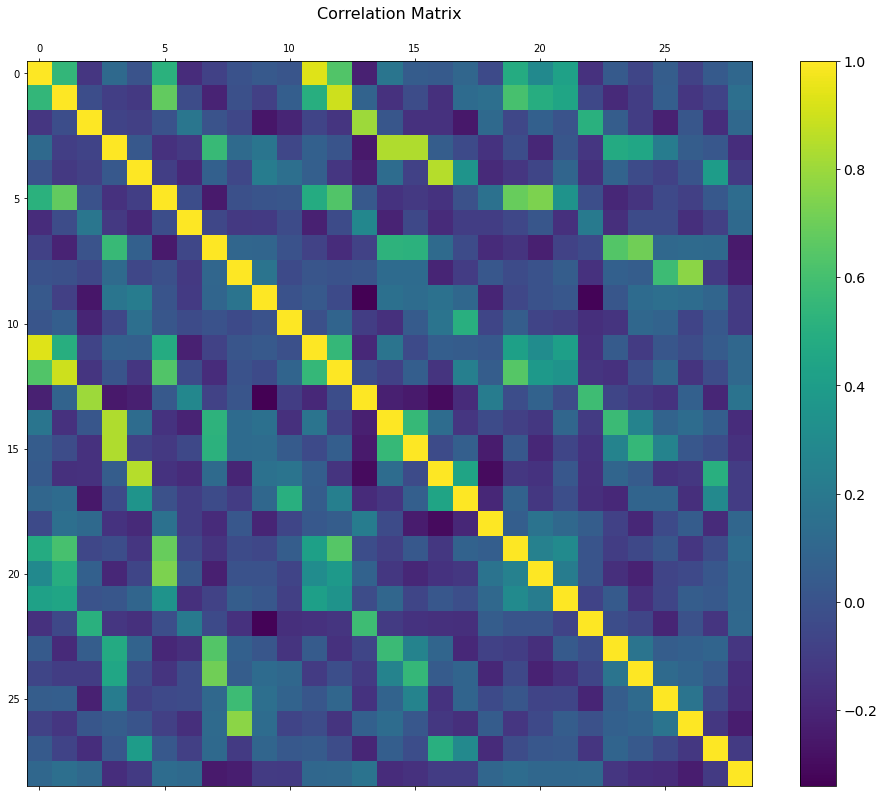

In [32]:
# Measure correlations between the extracted features and the events dataset.

f = plt.figure(figsize=(17, 13))
mini_input = np.transpose(mini)
maxi_input = np.transpose(maxi)
mini_input_two = np.transpose(mini_two)
maxi_input_two = np.transpose(maxi_two)


extremePoints = []

for i in mini_input:
  extremePoints.append(i)

for i in maxi_input:
  extremePoints.append(i)

for i in mini_input_two:
  extremePoints.append(i)

for i in maxi_input_two:
  extremePoints.append(i)

extremePoints_complete = []
for i in extremePoints:
  if np.corrcoef(i, events)[0][1] != 1:
    extremePoints_complete.append(i)

extremePoints_complete.append(events)
test = np.transpose(extremePoints_complete)
df = pd.DataFrame(test)

plt.matshow(df.corr(), fignum=f.number)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

# Feature extraction for attributes that describe intervals as a whole

As discussed earlier, this includes arrithmetic mean, standard deviation, baseline difference and extreme values

In [43]:
# Extract all features, that describe the intervals as a whole. Get these features for every possible frequency pattern
# to discover the highest possible correlations to the events dataset.

corr = []
corr_tapered = []
freqs = []
i = 1
limit = 50

while i < limit - 1:
  min = i
  c = i + 1
  while c < limit:
    max = c
    corr.append(getFeatures(min, max, data))
    corr_tapered.append(getFeatures(min, max, applyTapering(data, 10)))
    freqs.append([i,c])
    c += 1
  i += 1

cores = []
cores_tapered = []

for i in corr:
  for x in i:
    cores.append(np.corrcoef(x, events)[0][1])

for i in corr_tapered:
  for x in i:
    cores_tapered.append(np.corrcoef(x, events)[0][1])

0.22298810004690275

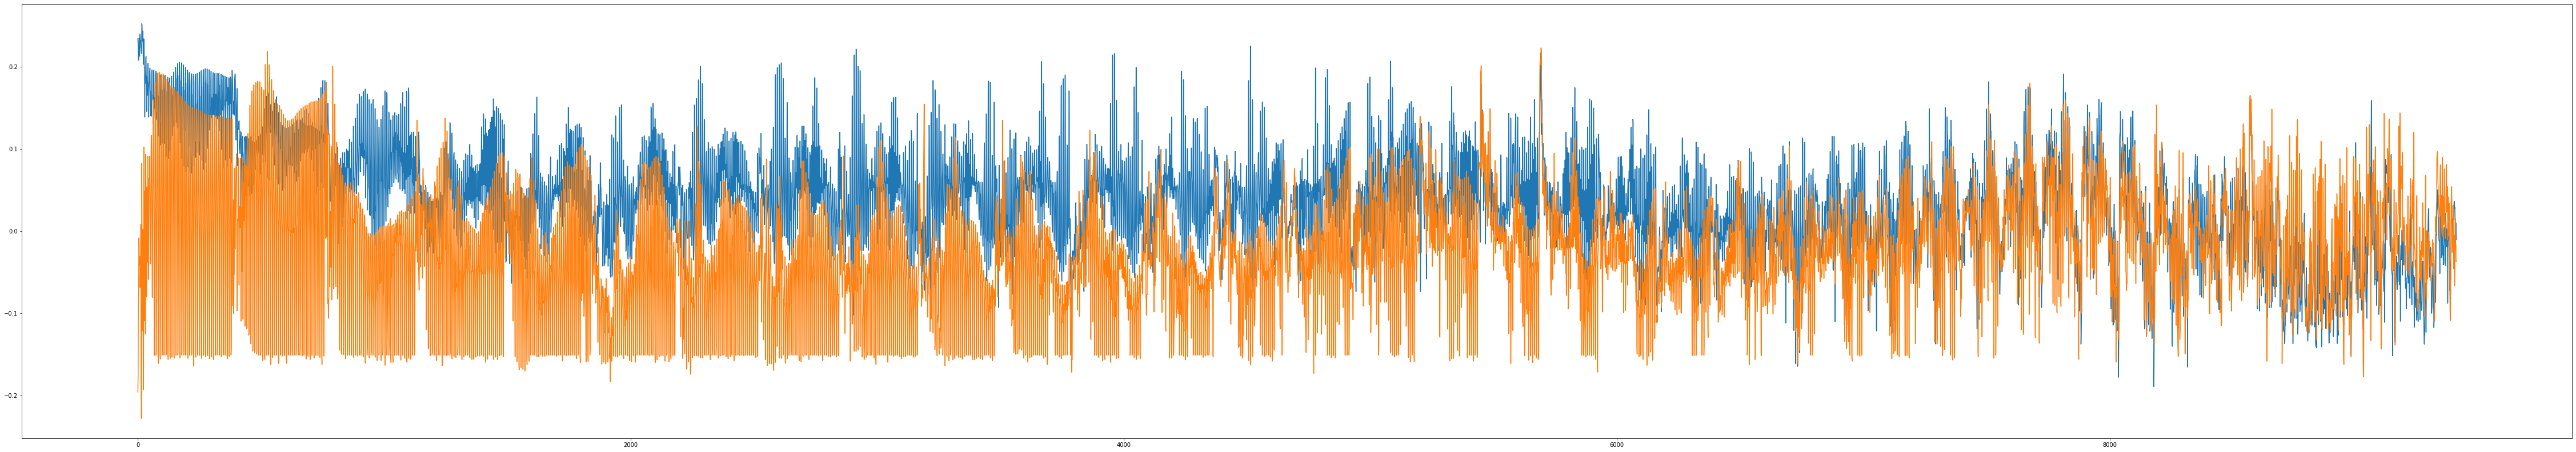

In [46]:
# Plot correlation of every extracted feature to event dataset

plt.figure(figsize=(80,14))

plt.plot(cores)
plt.plot(cores_tapered)

np.max(cores_tapered)

In [47]:
corr_ges = corr + corr_tapered
corr_flat_input = []

for i in corr_ges:
  for x in i:
    if math.sqrt(np.corrcoef(x, events)[0][1] ** 2) > 0.21:
      corr_flat_input.append(x)

In [48]:
# Cross out attributes with super high correlation to one another

def manageCrossCorrelation(corr_input):
  res = []
  a = 0

  for i in corr_input:
    c = 0
    corr_events = math.sqrt(np.corrcoef(i, events)[0][1] ** 2)

    if corr_events != 1:
      for x in corr_input:
        if i != x:
          inter_corr = math.sqrt(np.corrcoef(i, x)[0][1] ** 2)

          if inter_corr > 0.99:
            if corr_events > inter_corr:
              res.append(c)
            else:
              res.append(a)
      
      c += 1
    a += 1

  return res

corr_flat = []
cross_out = manageCrossCorrelation(corr_flat_input)
c = 0

for i in corr_flat_input:
  if c not in cross_out:
    corr_flat.append(i)
  c += 1

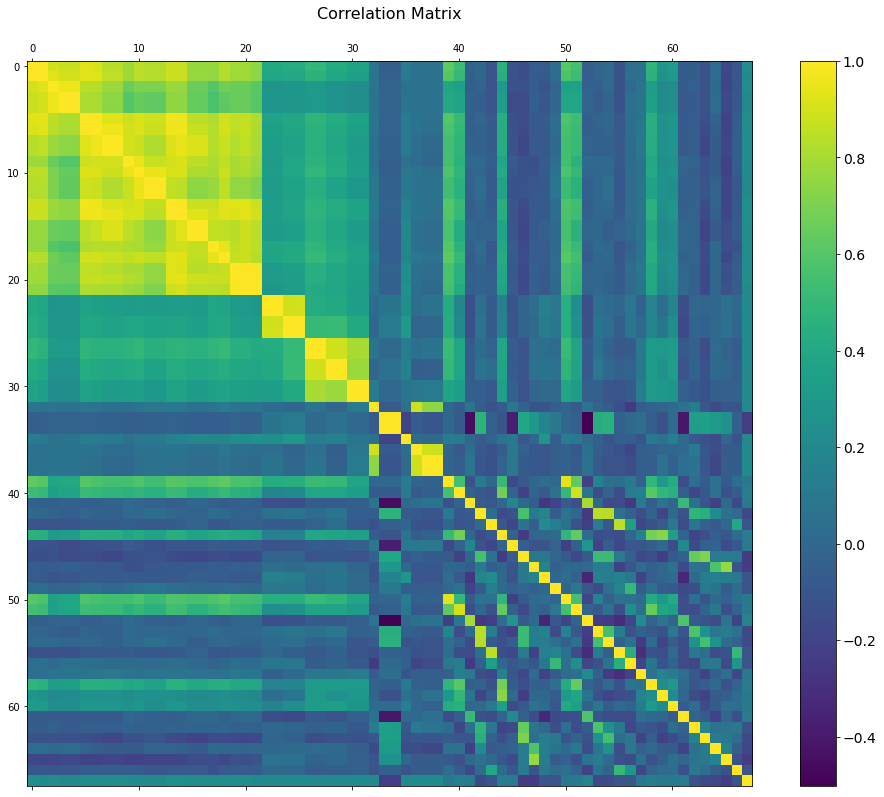

In [49]:
f = plt.figure(figsize=(17, 13))
mini_input = np.transpose(mini)
maxi_input = np.transpose(maxi)
mini_input_two = np.transpose(mini_two)
maxi_input_two = np.transpose(maxi_two)

for i in mini_input:
  corr_flat_input.append(i)

for i in maxi_input:
  corr_flat_input.append(i)

for i in mini_input_two:
  corr_flat_input.append(i)

for i in maxi_input_two:
  corr_flat_input.append(i)

corr_flat_complete = []
for i in corr_flat_input:
  if np.corrcoef(i, events)[0][1] != 1:
    corr_flat_complete.append(i)

corr_flat_complete.append(events)
test = np.transpose(corr_flat_complete)
df = pd.DataFrame(test)

plt.matshow(df.corr(), fignum=f.number)
#plt.xticks(np.arange(9), labels=["Means alpha", "Means beta", "std alpha", "std beta", "top val", "top val beta", "baseline alpha", "baseline beta", "events"])
#plt.yticks(np.arange(9), labels=["Means alpha", "Means beta", "std alpha", "std beta", "top val", "top val beta", "baseline alpha", "baseline beta", "events"])
#plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
#plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [50]:
#from sklearn.neighbors import NearestCentroid
#from sklearn.linear_model import TweedieRegressor

train = np.transpose(corr_flat_complete[:len(corr_flat_complete) - 1])
#train = np.transpose(extremePoints_complete[:len(extremePoints_complete) - 1])


train_end = 150
test_start = train_end + 1

c = 0
#predictions_raw = []
#for i in events:
 # predictions_raw.append([means_alpha[c], means_beta[c], std_alpha[c], std_beta[c], baseline_difference[c], baseline_difference_beta[c], top_val[c], top_val_beta[c], top_val_fft[c], means_alpha_fft[c], std_alpha_fft[c], means_beta_fft[c], std_beta_fft[c], top_val_beta_fft[c]])
 # c += 1

# define the data/predictors as the pre-set feature names  
dfTrain = pd.DataFrame(train[:train_end])
dfTest = pd.DataFrame(train[test_start:])

# Put the target (housing value -- MEDV) in another DataFrame
target = pd.DataFrame(events, columns=["MEDV"])

#clf = NearestCentroid()
clf = linear_model.Ridge(alpha=.5)
clf.fit(dfTrain, target[:train_end])



Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

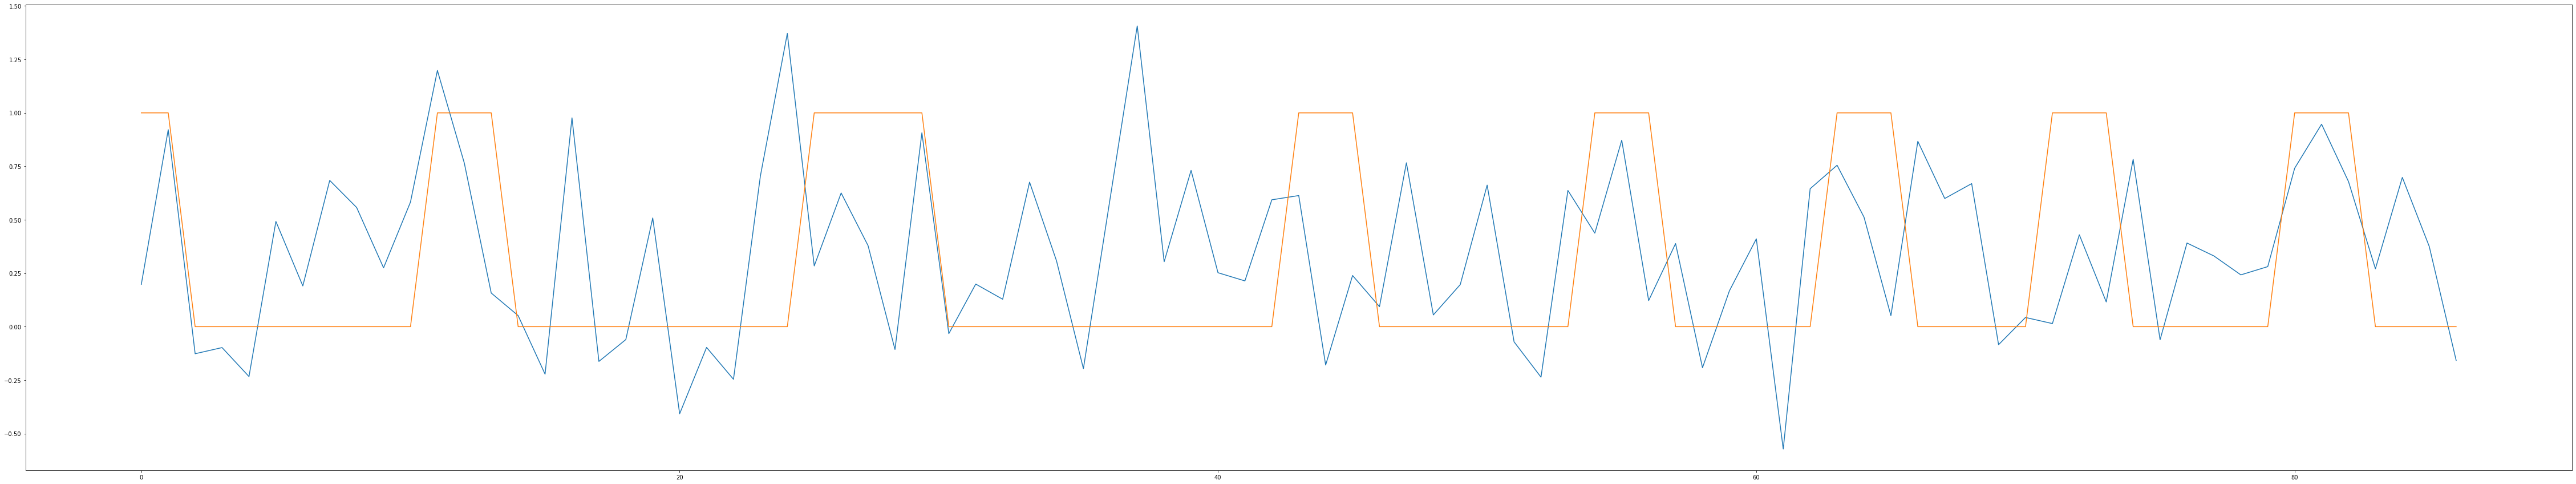

In [52]:
res = clf.predict(dfTest)

plt.figure(figsize=(80,15))

plt.plot(res)
plt.plot(events[test_start:])

# Linear Regression Model

In [53]:
train = np.transpose(corr_flat_complete[:len(corr_flat_complete) - 1])
#train = np.transpose(extremePoints_complete[:len(extremePoints_complete) - 1])

train_end = 150
test_start = train_end + 1

c = 0
#predictions_raw = []
#for i in events:
 # predictions_raw.append([means_alpha[c], means_beta[c], std_alpha[c], std_beta[c], baseline_difference[c], baseline_difference_beta[c], top_val[c], top_val_beta[c], top_val_fft[c], means_alpha_fft[c], std_alpha_fft[c], means_beta_fft[c], std_beta_fft[c], top_val_beta_fft[c]])
 # c += 1

# define the data/predictors as the pre-set feature names  
dfTrain = pd.DataFrame(train[:train_end])
dfTest = pd.DataFrame(train[test_start:])

# Put the target (housing value -- MEDV) in another DataFrame
target = pd.DataFrame(events, columns=["MEDV"])

lm = linear_model.LinearRegression()
model = lm.fit(dfTrain, target[:train_end])

In [54]:
lm.score(dfTrain, target[:train_end])
#lm.score(dfTest, target[test_start:])
#lm.score(pd.DataFrame(std_alpha[25:]),pd.DataFrame(events[60:]))

#len(corr_flat[0])
#corr_flat[len(corr_flat) - 1]

0.638451904270348

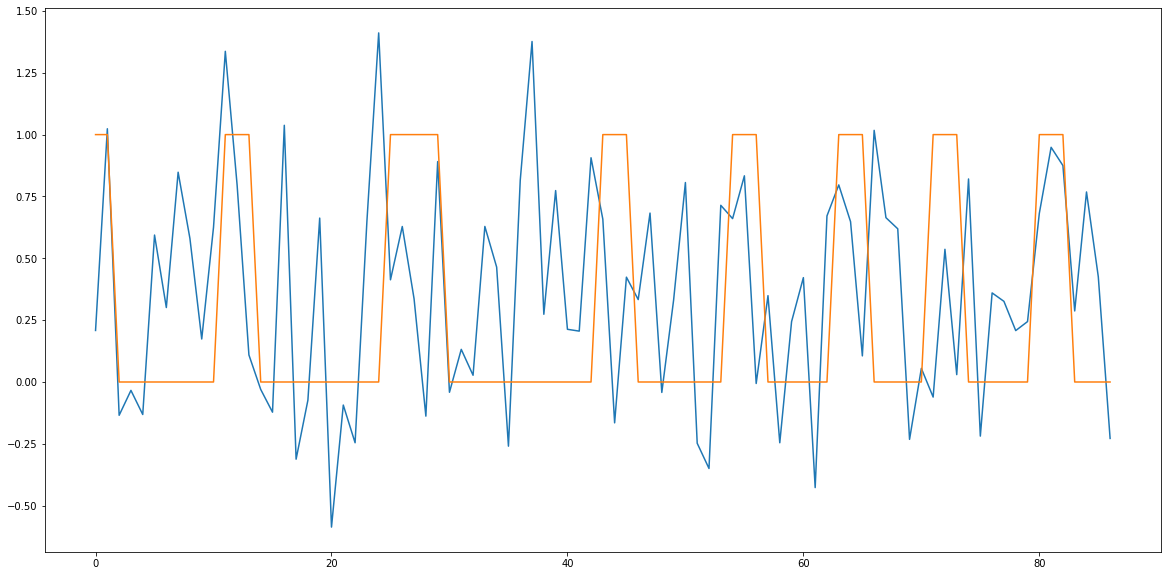

In [55]:
plt.figure(figsize=(20,10))
plt.plot(lm.predict(dfTest))
plt.plot(pd.DataFrame(events[test_start:]))


WINS / LOSSES GESAMT: 
59 28 0.6781609195402298
__________________________
WINS / LOSSES BEI 1: 
8 17 0.32
__________________________
WINS / LOSSES BEI 0: 
51 11 0.8225806451612904
__________________________
CORRELATION
[[1.         0.15616912]
 [0.15616912 1.        ]]

__________________________
CORRELATION TO ORIGINAL PREDICTIONS
[[1.         0.20085689]
 [0.20085689 1.        ]]



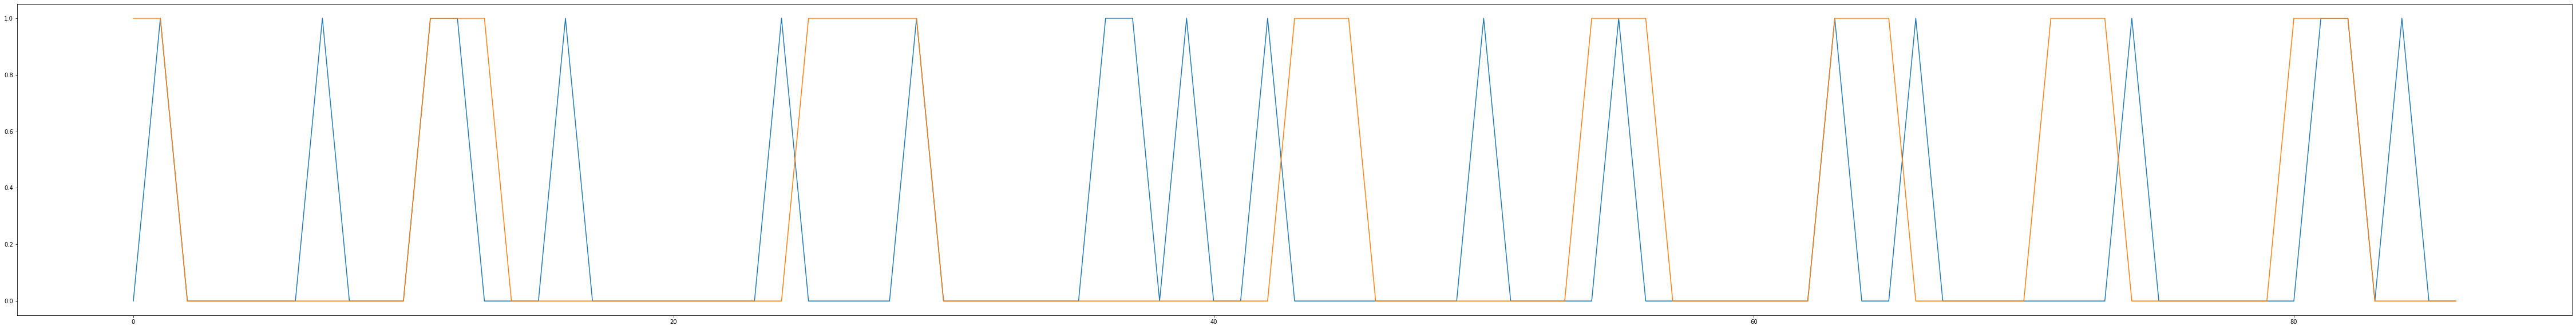

In [76]:
predictions = lm.predict(dfTest)
res = []
original_pred = []

for i in predictions[0:]:
  original_pred.append(i[0])
  if i > 0.75:
    res.append(1)
  else:
    res.append(0)
  
plt.figure(figsize=(80,10))
plt.plot(res)
plt.plot(events[test_start:])



c = 0
wins = 0
losses = 0

for i in events[test_start:]:
  if i == res[c]:
    wins += 1
  else:
    losses += 1
  c += 1

print("")
print("WINS / LOSSES GESAMT: ")
print(wins, losses, wins/(wins + losses))
print("__________________________")


c = 0
wins = 0
losses = 0

for i in events[test_start:]:
  if i == 1:
    if i == res[c]:
      wins += 1
    else:
      losses += 1
  c += 1

print("WINS / LOSSES BEI 1: ")
print(wins, losses, wins/(wins + losses))
print("__________________________")


c = 0
wins = 0
losses = 0

for i in events[test_start:]:
  if i == 0:
    if i == res[c]:
      wins += 1
    else:
      losses += 1
  c += 1

print("WINS / LOSSES BEI 0: ")
print(wins, losses, wins/(wins + losses))
print("__________________________")

print("CORRELATION")
print(np.corrcoef(res, events[test_start:]))
print("")
print("__________________________")

print("CORRELATION TO ORIGINAL PREDICTIONS")
print(np.corrcoef(original_pred, events[test_start:]))
print("")

# Random Forest Algorithm

In [57]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=10)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(dfTrain[:train_end],target[:train_end])

y_pred=clf.predict(dfTest)

In [58]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(events[test_start:], y_pred))

Accuracy: 0.735632183908046



WINS / LOSSES GESAMT: 
64 23 0.735632183908046
__________________________
WINS / LOSSES BEI 1: 
4 21 0.16
__________________________
WINS / LOSSES BEI 0: 
60 2 0.967741935483871
__________________________
CORRELATION
[[1.         0.22812937]
 [0.22812937 1.        ]]



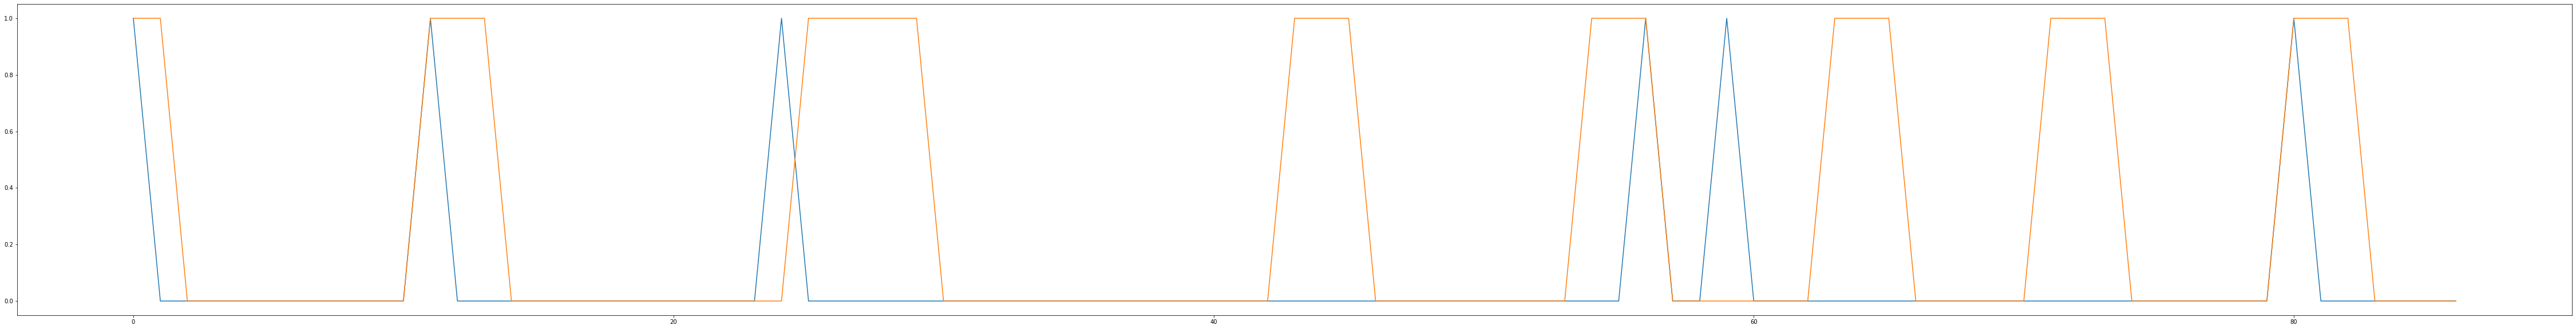

In [59]:
plt.figure(figsize=(80,10))
plt.plot(y_pred)
plt.plot(events[test_start:])


res = y_pred
c = 0
wins = 0
losses = 0

for i in events[test_start:]:
  if i == res[c]:
    wins += 1
  else:
    losses += 1
  c += 1

print("")
print("WINS / LOSSES GESAMT: ")
print(wins, losses, wins/(wins + losses))
print("__________________________")


c = 0
wins = 0
losses = 0

for i in events[test_start:]:
  if i == 1:
    if i == res[c]:
      wins += 1
    else:
      losses += 1
  c += 1

print("WINS / LOSSES BEI 1: ")
print(wins, losses, wins/(wins + losses))
print("__________________________")


c = 0
wins = 0
losses = 0

for i in events[test_start:]:
  if i == 0:
    if i == res[c]:
      wins += 1
    else:
      losses += 1
  c += 1

print("WINS / LOSSES BEI 0: ")
print(wins, losses, wins/(wins + losses))
print("__________________________")

print("CORRELATION")
print(np.corrcoef(res, events[test_start:]))
print("")

# Neural Network

In [60]:
xs_train = tf.constant(dfTrain)
xs_test = tf.constant(dfTest)

ys_train = tf.constant(events[:train_end])
ys_test = tf.constant(events[test_start:])

In [61]:
loss_fn = tf.keras.losses.MeanSquaredError()

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(len(xs_train[0]), 1)),
  tf.keras.layers.Dense(150, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

model.fit(xs_train, ys_train, batch_size=1, epochs=100)

Epoch 1/100
150/150 [==============================] - 1s 1ms/step - loss: 8506.7723 - accuracy: 0.4653
Epoch 2/100
150/150 [==============================] - 0s 1ms/step - loss: 4301.0722 - accuracy: 0.4935
Epoch 3/100
150/150 [==============================] - 0s 1ms/step - loss: 3201.8343 - accuracy: 0.5028
Epoch 4/100
150/150 [==============================] - 0s 1ms/step - loss: 60.1567 - accuracy: 0.4796
Epoch 5/100
150/150 [==============================] - 0s 1ms/step - loss: 877.8139 - accuracy: 0.4712
Epoch 6/100
150/150 [==============================] - 0s 1ms/step - loss: 916.8216 - accuracy: 0.4665
Epoch 7/100
150/150 [==============================] - 0s 1ms/step - loss: 104.7477 - accuracy: 0.5524
Epoch 8/100
150/150 [==============================] - 0s 1ms/step - loss: 306.1324 - accuracy: 0.4800
Epoch 9/100
150/150 [==============================] - 0s 1ms/step - loss: 72.0974 - accuracy: 0.5258
Epoch 10/100
150/150 [==============================] - 0s 1ms/step - lo

3/3 [==============================] - 0s 4ms/step - loss: 1.3868 - accuracy: 0.7011


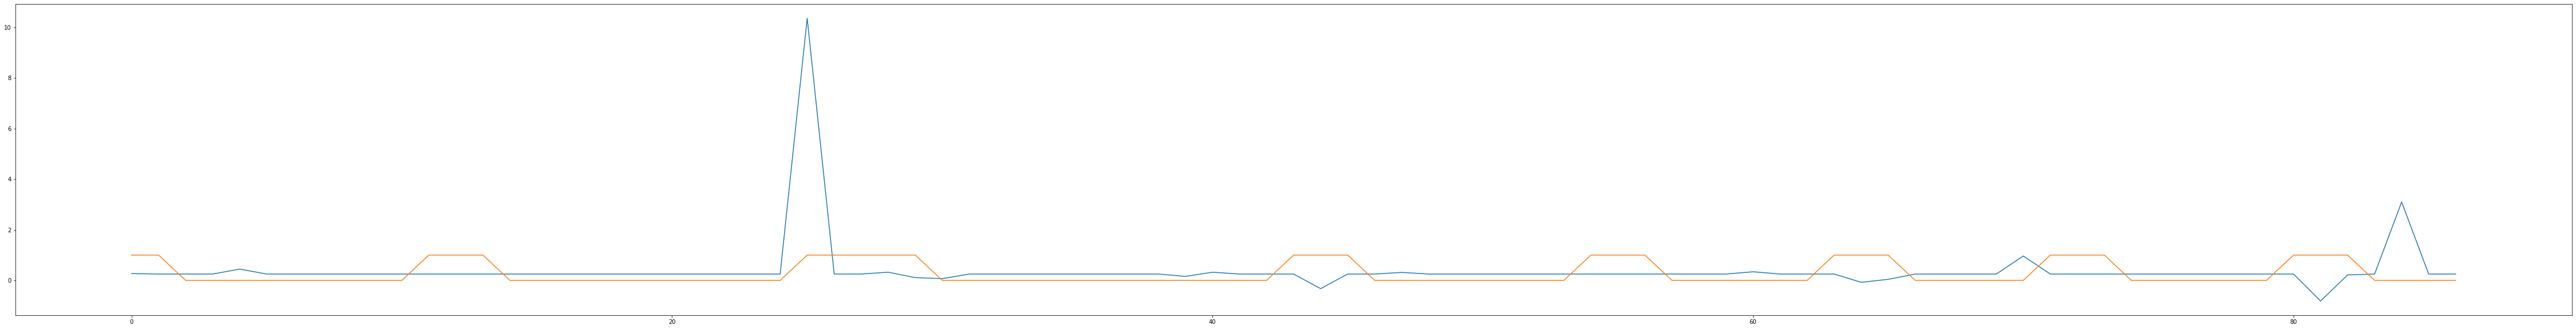

In [62]:
model.evaluate(xs_test, ys_test)

plt.figure(figsize=(80,10))

plt.plot(model.predict(xs_test))
plt.plot(events[test_start:])


WINS / LOSSES GESAMT: 
60 27 0.6896551724137931
__________________________
WINS / LOSSES BEI 1: 
4 21 0.16
__________________________
WINS / LOSSES BEI 0: 
56 6 0.9032258064516129
__________________________
CORRELATION
[[1.         0.08970463]
 [0.08970463 1.        ]]



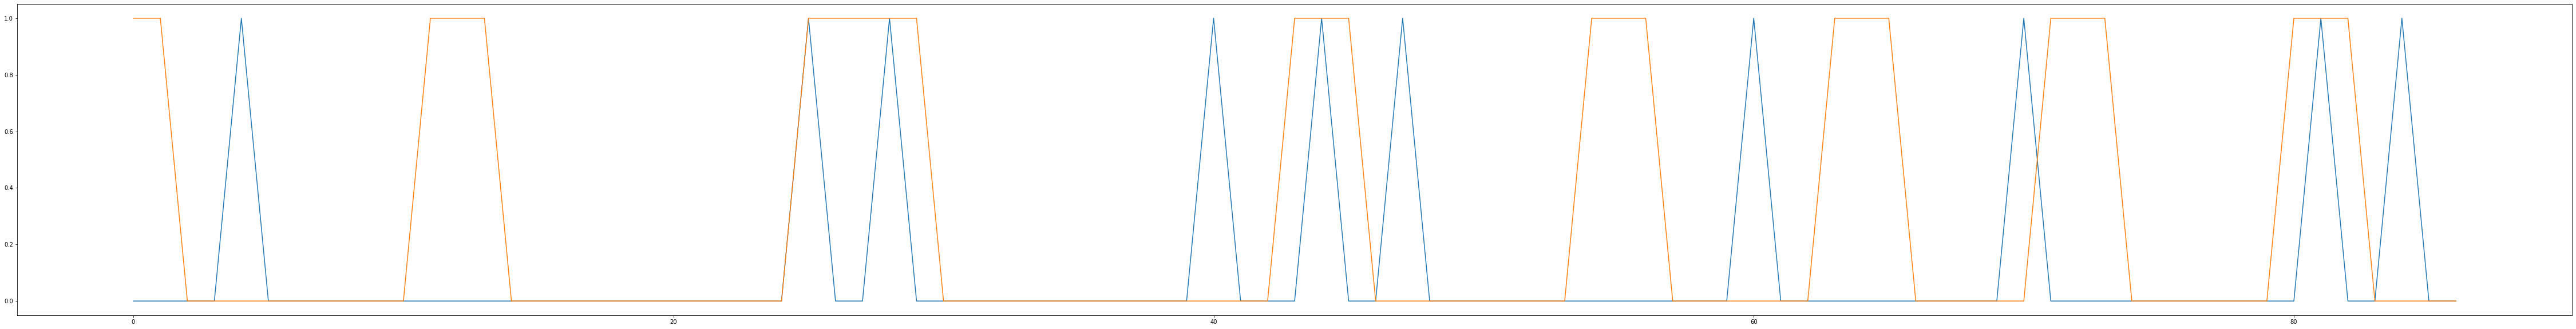

In [72]:
predictions = model.predict(xs_test)
res = []

for i in predictions[0:]:
  if i > 0.27 or i < -0.27:
    res.append(1)
  else:
    res.append(0)
  
plt.figure(figsize=(80,10))
plt.plot(res)
plt.plot(events[test_start:])



c = 0
wins = 0
losses = 0

for i in events[test_start:]:
  if i == res[c]:
    wins += 1
  else:
    losses += 1
  c += 1

print("")
print("WINS / LOSSES GESAMT: ")
print(wins, losses, wins/(wins + losses))
print("__________________________")


c = 0
wins = 0
losses = 0

for i in events[test_start:]:
  if i == 1:
    if i == res[c]:
      wins += 1
    else:
      losses += 1
  c += 1

print("WINS / LOSSES BEI 1: ")
print(wins, losses, wins/(wins + losses))
print("__________________________")


c = 0
wins = 0
losses = 0

for i in events[test_start:]:
  if i == 0:
    if i == res[c]:
      wins += 1
    else:
      losses += 1
  c += 1

print("WINS / LOSSES BEI 0: ")
print(wins, losses, wins/(wins + losses))
print("__________________________")

print("CORRELATION")
print(np.corrcoef(res, events[test_start:]))
print("")